In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
# from scipy import spatial

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

## Observed mutations

#### Prepapre table for best friend of KP

In [156]:
mut_tcga = pd.read_csv("../data/processed/mutations.csv")

mut_tcga = mut_tcga[mut_tcga.Type != 'D-loop']
mut_tcga['sbs192heavy'] = mut_tcga['Mut'].apply(rev_comp)
mut_tcga['sbs12heavy'] = mut_tcga['sbs192heavy'].str.slice(2,5)
mut_tcga.drop(['Mut', 'sbs192heavy', 'Strand', 'AltCodon', 'Codon', 'PosInCodon', 'PosInGene', 'Context', 'Nuc', 'Label'], axis=1, inplace=True)
print(mut_tcga.shape)
mut_tcga.head()

(6628, 8)


,tissue,TurnOverDays,tumor_var_freq,Pos,Type,GeneName,TBSS,sbs12heavy
0,Bladder,200.0,38.7900,2680,rRNA,RNR2,10487.0,A>G
1,Pancreas,360.0,21.0500,2680,rRNA,RNR2,10487.0,A>G
2,Bladder,200.0,10.1400,6011,CDS,COX1,426.0,A>G
3,Bladder,200.0,37.3900,7706,CDS,COX2,3816.0,C>T
4,Esophagus,11.0,0.7013,7706,CDS,COX2,3816.0,C>T


In [157]:
mut_tcga.to_csv('../data/processed/all_muts_strand1.csv', index=False)

### TCGA

In [158]:
mut_tcga = pd.read_csv("../data/processed/mutations.csv")
mut_tcga['sbs12'] = mut_tcga['Mut'].str.slice(2,5)
print(mut_tcga.shape)
mut_tcga.head()

(7611, 17)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut,sbs12
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G,T>C
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G,T>C
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A,T>C
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A


In [159]:
mut_tcga.tissue.value_counts()

Liver              1273
Pancreas            861
Kidney              822
Prostate            739
Breast              689
Esophagus           409
Ovary               402
Lymphoid            316
Lung                268
CNS                 262
Colon/Rectum        224
Skin                217
Stomach             210
Thyroid             168
Bone/SoftTissue     155
Head/Neck           146
Uterus              145
Bladder              99
Biliary              90
Myeloid              78
Cervix               38
Name: tissue, dtype: int64

### gTEX

In [65]:
mut_gtex = pd.read_csv('../data/stem_and_workers/gtex_annotated.csv')
mut_gtex['sbs12'] = mut_gtex['Mut'].str.slice(2,5)
print(mut_gtex.shape)
mut_gtex.head()

(2565, 25)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,...,Nuc,Context,Strand,Type,product,PosInGene,PosInCodon,Codon,Mut,sbs12
0,1554,1554_A,SRR1500555,0.1021,Artery - Tibial,GTEX-1117F,13,35.7,186,0.0012,...,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A,G>A
1,1554,1554_A,SRR1096458,0.0347,Ovary,GTEX-TML8,14,38.4,144,0.0021,...,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A,G>A
2,1554,1554_A,SRR1102224,0.0309,Colon - Sigmoid,GTEX-V955,20,35.2,906,0.0011,...,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A,G>A
3,1554,1554_A,SRR1433514,0.0326,Cells - Transformed fibroblasts,GTEX-WY7C,30,33.2,491,0.0019,...,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A,G>A
4,16215,16215_A,SRR1413373,0.0525,Ovary,GTEX-1117F,13,37.9,362,0.0000,...,G,AGC,-1,D-loop,NaN,-1,-1,NaN,A[G>A]C,G>A


In [5]:
mut_gtex.tissue.value_counts()

Whole Blood                                  452
Cells - Transformed fibroblasts              330
Esophagus - Mucosa                           191
Cells - EBV-transformed lymphocytes          162
Skin - Sun Exposed (Lower leg)               122
Nerve - Tibial                               113
Thyroid                                      110
Liver                                         94
Adrenal Gland                                 83
Muscle - Skeletal                             81
Artery - Aorta                                79
Lung                                          70
Adipose - Subcutaneous                        62
Artery - Tibial                               49
Pituitary                                     43
Testis                                        40
Prostate                                      40
Ovary                                         38
Skin - Not Sun Exposed (Suprapubic)           37
Kidney - Cortex                               36
Pancreas            

## Expected mutations

In [6]:
with open("../data/processed/expected_sbs12.json") as handle:
    exp_muts12 = json.load(handle)

pd.DataFrame(exp_muts12).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A>C,766,766,3148,325,339,861,527,4785
A>G,766,1308,3148,325,339,861,527,4785
A>T,766,766,3148,325,339,861,527,4785
C>A,817,817,3579,390,371,650,353,4810
C>G,817,817,3579,390,371,650,353,4810
C>T,817,1872,3579,390,371,650,353,4810
G>A,96,178,1294,137,150,451,217,2015
G>C,96,96,1294,137,150,451,217,2015
G>T,96,96,1294,137,150,451,217,2015
T>A,261,261,2758,286,260,548,405,3834


In [7]:
ref_annot = pd.read_csv('../data/processed/ref_annot.csv')
ref_annot

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16564,16565,C,ACG,-1,D-loop,NaN,-1,-1,NaN,NaN
16565,16566,G,CGA,-1,D-loop,NaN,-1,-1,NaN,NaN
16566,16567,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
16567,16568,T,ATG,-1,D-loop,NaN,-1,-1,NaN,NaN


## Spectra compares

In [66]:
def get_asymmetry(spectrum: pd.DataFrame):
    """
    work with light strand

    - AhGh/ChTh
    - Tv/ChTh
    """
    dct = spectrum.set_index("Mut")['MutSpec'].to_dict()
    tv_mut_types = ['A>C', 'A>T', 'C>A', 'C>G',  'G>C', 'G>T', 'T>A', 'T>G']
    dct['Tv'] = 0.
    for x in tv_mut_types:
        dct['Tv'] += dct.get(x, 0.)
    
    try:   
        tc_ga = dct.get('T>C') / dct.get('G>A')
    except:
        tc_ga = None
    try:   
        tv_ga = dct.get('Tv') / dct.get('G>A')
    except:
        tv_ga = None
    try:   
        tv_tc = dct.get('Tv') / dct.get('T>C')
    except:
        tv_tc = None
    
    return [tc_ga, tv_ga, tv_tc]

In [160]:
mut_tcga_ex_ctrl_reg = mut_tcga[(mut_tcga.Type != "D-loop")]
mut_gtex_ex_ctrl_reg = mut_gtex[(mut_gtex.Type != "D-loop")]
print('nmuts:', mut_tcga_ex_ctrl_reg.shape[0], mut_gtex_ex_ctrl_reg.shape[0])

nmuts: 6628 2148


#### Plot total spectra

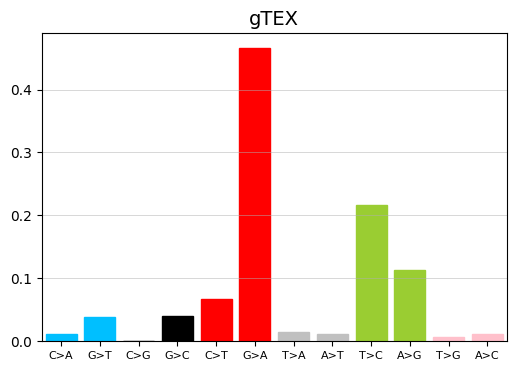

<AxesSubplot:title={'center':'gTEX'}>

In [ ]:
plot_mutspec12(calculate_mutspec(mut_gtex_ex_ctrl_reg, exp_muts12['ExDloop']), 
               title='gTEX')

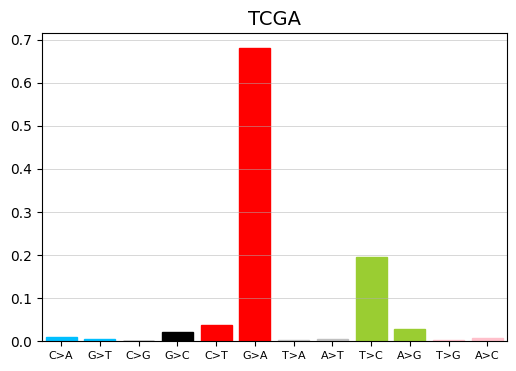

<AxesSubplot:title={'center':'TCGA'}>

In [ ]:
plot_mutspec12(calculate_mutspec(mut_tcga_ex_ctrl_reg, exp_muts12['ExDloop']),
               title='TCGA')

### Tissue specific spectra

In [161]:
data = []
mut = mut_tcga_ex_ctrl_reg
for tissue, sample in mut.groupby('tissue'):
    if len(sample) < 20:
        print(f"Don't calculate spectrum for {tissue}: less than 20 mutations")
        continue

    spectrum = calculate_mutspec(
        sample, exp_muts12['ExDloop'], fill_unobserved=False)
    one = get_asymmetry(spectrum)
    data.append([tissue] + one)

asymmetry_tcga = pd.DataFrame(
    data, columns=['tissue', 'AhGh/ChTh', 'Tv/ChTh', 'Tv/AhGh']
).set_index('tissue')

In [215]:
CancerTissue = (
    'Bladder','Bone/SoftTissue','Breast','Biliary','Cervix','Lymphoid','Myeloid',
    'Colon/Rectum','Prostate','Esophagus','Stomach','CNS','Head/Neck','Kidney',
    'Liver','Lung','Ovary','Pancreas','Skin','Thyroid','Uterus',
)  
TurnOverDays = (
    200,5373,84.5,200,6,30,30,5,120,11,5.5,10000,16,1000,400,5143,11000,360,147,4138,4,
) 
_turn_mapper = dict(zip(CancerTissue, TurnOverDays))
Turn = pd.Series(_turn_mapper).sort_values().reset_index()\
    .rename(columns={"index": "tissue", 0: "TurnOverDays"}).set_index('tissue')
Turn["DummyShortTurnoverTime"] = Turn["TurnOverDays"] < 50
Turn["DummyMediumTurnoverTime"] = Turn["TurnOverDays"].between(50, 500)
Turn["DummyLongTurnoverTime"] = Turn["TurnOverDays"] > 500
Turn['TurnOverRank'] =  Turn["DummyShortTurnoverTime"] * 1 + \
                        Turn["DummyMediumTurnoverTime"] * 2 + \
                        Turn["DummyLongTurnoverTime"] * 3
print(Turn.TurnOverDays.describe())
Turn.to_csv('../data/TurnOverRate.csv')
Turn

count       21.00000
mean      1822.52381
std       3354.87855
min          4.00000
25%         16.00000
50%        147.00000
75%       1000.00000
max      11000.00000
Name: TurnOverDays, dtype: float64


,TurnOverDays,DummyShortTurnoverTime,DummyMediumTurnoverTime,DummyLongTurnoverTime,TurnOverRank
tissue,,,,,
Uterus,4.0,True,False,False,1
Colon/Rectum,5.0,True,False,False,1
Stomach,5.5,True,False,False,1
Cervix,6.0,True,False,False,1
Esophagus,11.0,True,False,False,1
Head/Neck,16.0,True,False,False,1
Lymphoid,30.0,True,False,False,1
Myeloid,30.0,True,False,False,1
Breast,84.5,False,True,False,2


In [167]:
asymmetry_tcga_w_turn = asymmetry_tcga.join(Turn[['TurnOverRank']] / 5)
# asymmetry_tcga_w_turn['TurnOverDays'] = asymmetry_tcga_w_turn['TurnOverDays'] / asymmetry_tcga_w_turn['TurnOverDays'].sum()

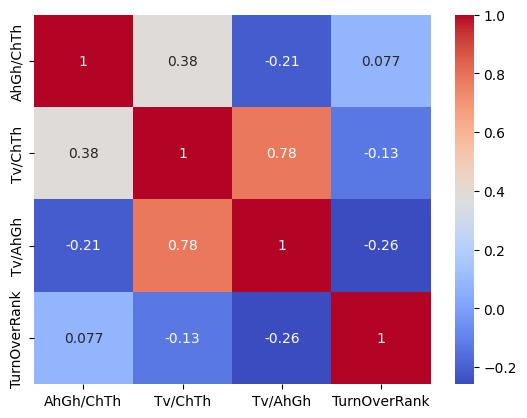

In [170]:
sns.heatmap(asymmetry_tcga_w_turn.corr('spearman'), annot=True, cmap='coolwarm');

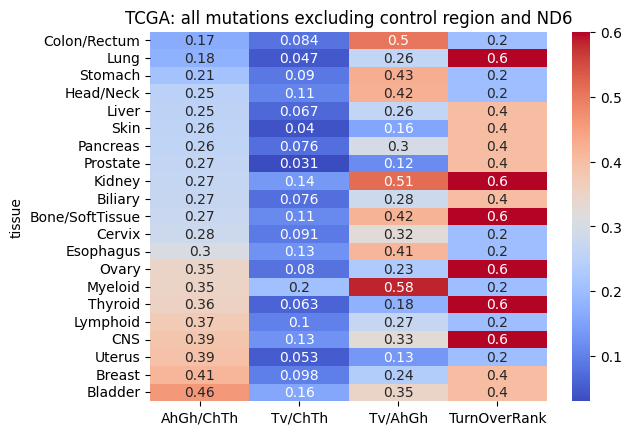

In [171]:
sns.heatmap(asymmetry_tcga_w_turn.sort_values('AhGh/ChTh'), 
            annot=True, cmap='coolwarm')#, cbar_kws={'label': 'asymmetry'})
plt.title('TCGA: all mutations excluding control region and ND6')
# plt.xticks(rotation=-90)
plt.show()

In [197]:
data = []
mut = mut_gtex_ex_ctrl_reg
for tissue, sample in mut.groupby('tissue'):
    if len(sample) < 20:
        print(f"Don't calculate spectrum for {tissue}: less than 20 mutations")
        continue

    spectrum = calculate_mutspec(sample, exp_muts12['ExDloop'], fill_unobserved=False)
    one = get_asymmetry(spectrum)
    data.append([tissue] + one)

asymmetry_gtex = pd.DataFrame(data, columns=['tissue', 'AhGh/ChTh', 'Tv/ChTh', 'Tv/AhGh'])\
                    .sort_values('AhGh/ChTh').set_index('tissue')

Don't calculate spectrum for Artery - Coronary: less than 20 mutations
Don't calculate spectrum for Brain - Anterior cingulate cortex (BA24): less than 20 mutations
Don't calculate spectrum for Brain - Cerebellar Hemisphere: less than 20 mutations
Don't calculate spectrum for Brain - Cortex: less than 20 mutations
Don't calculate spectrum for Brain - Frontal Cortex (BA9): less than 20 mutations
Don't calculate spectrum for Brain - Hippocampus: less than 20 mutations
Don't calculate spectrum for Brain - Hypothalamus: less than 20 mutations
Don't calculate spectrum for Brain - Nucleus accumbens (basal ganglia): less than 20 mutations
Don't calculate spectrum for Brain - Spinal cord (cervical c-1): less than 20 mutations
Don't calculate spectrum for Esophagus - Gastroesophageal Junction: less than 20 mutations
Don't calculate spectrum for Esophagus - Muscularis: less than 20 mutations
Don't calculate spectrum for Heart - Atrial Appendage: less than 20 mutations
Don't calculate spectrum fo

In [ ]:
turnoverdays_gtex = {
    'Skin - Not Sun Exposed (Suprapubic)': 147,
    'Liver': 400,
    'Colon - Transverse': 5,
    'Skin - Sun Exposed (Lower leg)': 147,
    'Thyroid': 4138,
    'Esophagus - Mucosa': 11,
    'Lung': 5143,
    'Colon - Sigmoid': 5,
    'Breast - Mammary Tissue': 84.5,
    'Pancreas': 360,
    'Ovary': 11000,
    'Prostate': 120,
    'Adipose - Visceral (Omentum)': ,
    'Testis': ,
    'Artery - Aorta': ,
    'Pituitary': ,
    'Artery - Tibial': ,
    'Nerve - Tibial': ,
    'Whole Blood': ,
    'Muscle - Skeletal': ,
    'Adrenal Gland': ,
    'Adipose - Subcutaneous': ,
}

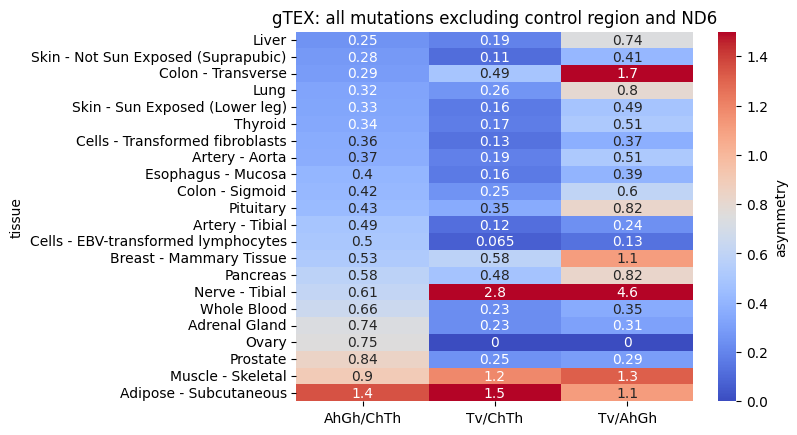

In [62]:
sns.heatmap(asymmetry_gtex, annot=True, cmap='coolwarm', cbar_kws={'label': 'asymmetry'}, vmax=1.5)
plt.title('gTEX: all mutations excluding control region and ND6');

In [123]:
mut_gtex_ex_ctrl_reg[mut_gtex_ex_ctrl_reg.tissue == 'Muscle - Skeletal'].Mut.str.slice(2, 5).value_counts()


T>C    12
G>A     7
A>G     6
T>A     5
C>T     3
G>C     3
A>C     3
A>T     1
G>T     1
Name: Mut, dtype: int64

In [44]:
# Nerve - Tibial samples contain a lot of G>T 
mut_gtex_ex_ctrl_reg[mut_gtex_ex_ctrl_reg.tissue == 'Nerve - Tibial'].Mut.str.slice(2, 5).value_counts()

G>T    25
A>G    20
T>C    14
G>A    12
C>T    11
G>C     6
A>T     4
T>A     1
A>C     1
C>A     1
Name: Mut, dtype: int64

### Interval-based spectra
Features:
- cancer/tissue type
- location (TSSS)
- MutType (A>G, C>T, ratios, etc.)
- VAF (optionaly)

#### split to intervals

In [179]:
# start and end of the mt genome excluding D-loop
ref_annot[ref_annot.Type != 'D-loop'].Pos.describe().loc[['min', 'max']]

min      577.0
max    16023.0
Name: Pos, dtype: float64

In [180]:
nintervals = 15
genome_points = np.linspace(577, 16024, nintervals).astype(int)
print(genome_points)
site2genome_point = defaultdict(int)
for iid, (x,y) in enumerate(zip(genome_points[:-1], genome_points[1:]), 1):
    for i in range(x, y):
        site2genome_point[i] = iid

[  577  1680  2783  3887  4990  6093  7197  8300  9403 10507 11610 12713
 13817 14920 16024]


In [181]:
mut_tcga['interval'] = mut_tcga.Pos.map(site2genome_point)
ref_annot['interval'] = ref_annot.Pos.map(site2genome_point)

In [182]:
mut_tcga.head()

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut,sbs12,interval
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G,T>C,2
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G,T>C,2
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A,T>C,5
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A,7
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A,7


In [183]:
mut_tcga[mut_tcga.interval == 0].Type.value_counts()

D-loop    983
Name: Type, dtype: int64

In [184]:
intervals_stats = mut_tcga.groupby('interval').agg({'Pos':['min', 'max'], 'Mut': 'count'})
intervals_stats['Len'] = intervals_stats[('Pos',   'max')] - intervals_stats[('Pos',   'min')]
intervals_stats.iloc[0, 3] = ref_annot[ref_annot.Type == 'D-loop'].shape[0]
intervals_stats.to_csv('../data/intervals_stats.csv')
intervals_stats

Pos          Mut   Len
            min    max count      
interval                          
0            35  16566   983  1122
1           577   1671   557  1094
2          1682   2778   555  1096
3          2786   3880   567  1094
4          3887   4986   509  1099
5          5007   6087   431  1080
6          6093   7196   431  1103
7          7201   8292   390  1091
8          8309   9401   316  1092
9          9411  10505   422  1094
10        10521  11602   447  1081
11        11613  12705   517  1092
12        12722  13813   512  1091
13        13818  14918   420  1100
14        14921  16023   554  1102

In [185]:
interval_tis_mut_counts = mut_tcga.groupby([ 'interval', 'tissue',])\
    .Mut.count().rename('nmuts').unstack()
interval_tis_mut_counts.to_csv('../data/interval_tis_mut_counts.csv', float_format='%g')
interval_tis_mut_counts.head(2)

tissue,Biliary,Bladder,Bone/SoftTissue,Breast,CNS,Cervix,Colon/Rectum,Esophagus,Head/Neck,Kidney,...,Lung,Lymphoid,Myeloid,Ovary,Pancreas,Prostate,Skin,Stomach,Thyroid,Uterus
interval,,,,,,,,,,,,,,,,,,,,,
0,9.0,11.0,25.0,99.0,36.0,5.0,42.0,61.0,22.0,148.0,...,31.0,30.0,7.0,33.0,96.0,80.0,25.0,30.0,15.0,7.0
1,7.0,3.0,12.0,50.0,10.0,1.0,20.0,32.0,18.0,51.0,...,19.0,43.0,6.0,20.0,52.0,66.0,20.0,13.0,8.0,9.0


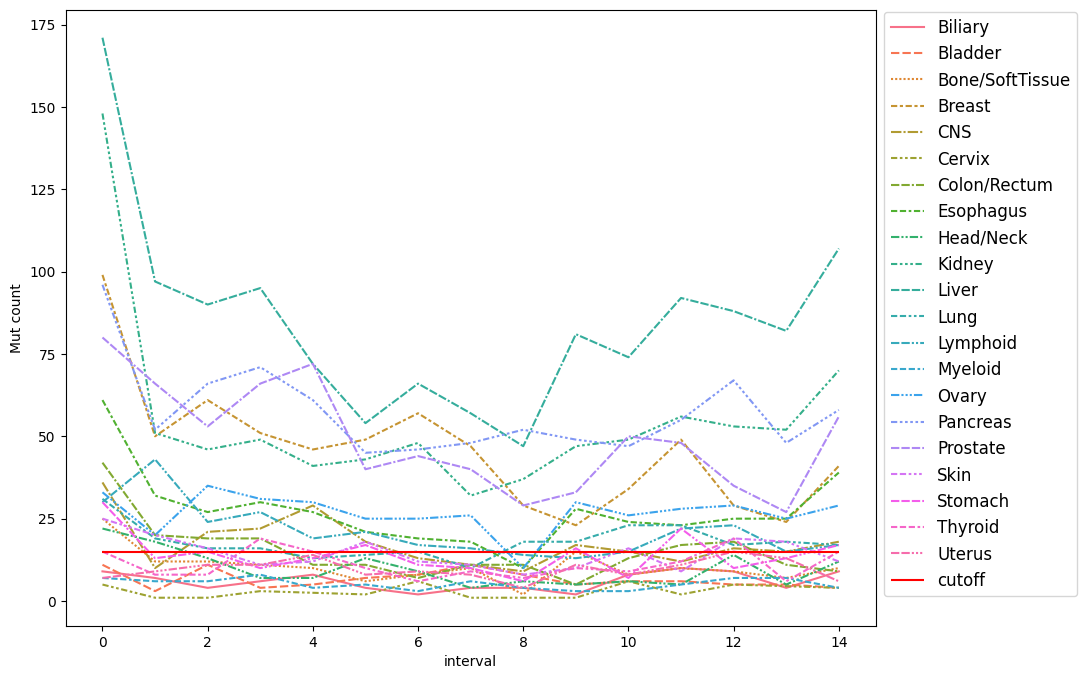

In [186]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(interval_tis_mut_counts)
plt.hlines(15, 0, 14, 'red', label='cutoff')
ax.set_ylabel('Mut count')
# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.show()

#### Check that spectra in different interfals and genes are similar

##### Intervals

In [92]:
interval_nuc_cnt = ref_annot.groupby(['interval', 'Nuc']).Nuc.count()\
    .unstack().fillna(0.).astype(int)
interval_nuc_cnt

Nuc,A,C,G,T
interval,,,,
0,339,371,152,260
1,365,293,203,242
2,405,277,186,235
3,326,345,168,264
4,342,349,133,279
5,339,350,142,272
6,290,337,173,304
7,333,331,164,275
8,359,366,114,264


In [93]:
interval_obs12 = mut_tcga.groupby(['interval', 'sbs12']).Mut.count()\
    .unstack().fillna(0.).astype(int)
interval_obs12

sbs12,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
interval,,,,,,,,,,,,
0,11,131,7,42,6,300,211,7,17,6,236,9
1,3,28,8,7,2,17,354,11,3,1,122,1
2,5,37,6,5,0,24,344,14,2,4,111,3
3,1,38,4,13,5,31,327,11,1,1,134,1
4,3,22,5,7,1,39,283,5,1,6,134,3
5,7,25,2,6,3,46,186,6,4,1,144,1
6,2,28,3,6,0,35,216,12,3,2,122,2
7,7,19,3,14,1,20,196,5,3,1,121,0
8,2,12,9,2,1,31,151,2,1,2,103,0


In [124]:
interval_spectra12 = interval_obs12.join(interval_nuc_cnt)
for sbs in possible_sbs12:
    interval_spectra12[sbs] = interval_spectra12[sbs] / interval_spectra12[sbs[0]]

interval_spectra12 = (interval_spectra12[possible_sbs12].T / \
                      interval_spectra12[possible_sbs12].sum(axis=1)).T

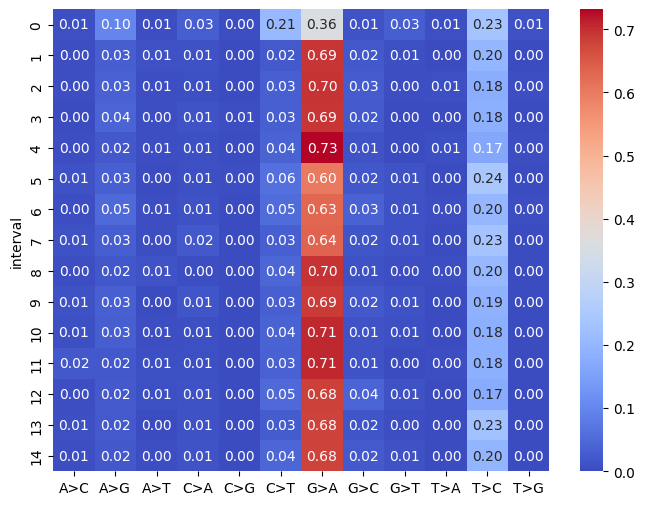

In [126]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(interval_spectra12, cmap='coolwarm', annot=True, fmt='.2f');

##### Genes

In [140]:
genes_size = ref_annot.GeneName.value_counts()
used_genes = genes_size[genes_size > 200].index.values
print(used_genes)
# genes_size

['ND5' 'RNR2' 'COX1' 'ND4' 'CYTB' 'ND2' 'ND1' 'RNR1' 'COX3' 'COX2' 'ATP6'
 'ND6' 'ND3' 'ND4L']


In [134]:
gene_nuc_cnt = ref_annot.groupby(['GeneName', 'Nuc']).Nuc.count()\
    .unstack().fillna(0.).astype(int).loc[used_genes]
gene_nuc_cnt

Nuc,A,C,G,T
GeneName,,,,
ND5,551,622,192,447
RNR2,547,397,270,344
COX1,419,463,250,410
ND4,416,473,137,352
CYTB,326,391,137,287
ND2,326,349,99,268
ND1,272,344,112,228
RNR1,315,253,181,205
COX3,210,249,116,209


In [141]:
gene_obs12 = mut_tcga.groupby(['GeneName', 'sbs12']).Mut.count()\
    .unstack().fillna(0.).astype(int).loc[used_genes]
gene_obs12

sbs12,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
GeneName,,,,,,,,,,,,
ND5,19,39,10,20,1,82,380,20,4,2,253,0
RNR2,5,55,9,11,2,35,508,22,2,5,165,4
COX1,7,41,4,11,0,50,296,16,5,2,177,2
ND4,11,29,8,13,0,47,302,4,2,1,178,2
CYTB,7,16,3,12,1,44,315,7,4,0,176,1
ND2,1,17,2,5,2,44,179,4,0,0,150,1
ND1,2,20,3,10,3,28,237,4,1,3,117,3
RNR1,3,27,7,5,1,15,305,10,3,1,112,1
COX3,7,9,4,8,0,20,184,5,3,0,97,1


In [144]:
gene_spectra12 = gene_obs12.join(gene_nuc_cnt)
for sbs in possible_sbs12:
    gene_spectra12[sbs] = gene_spectra12[sbs] / gene_spectra12[sbs[0]]

gene_spectra12 = (gene_spectra12[possible_sbs12].T / \
                  gene_spectra12[possible_sbs12].sum(axis=1)).T

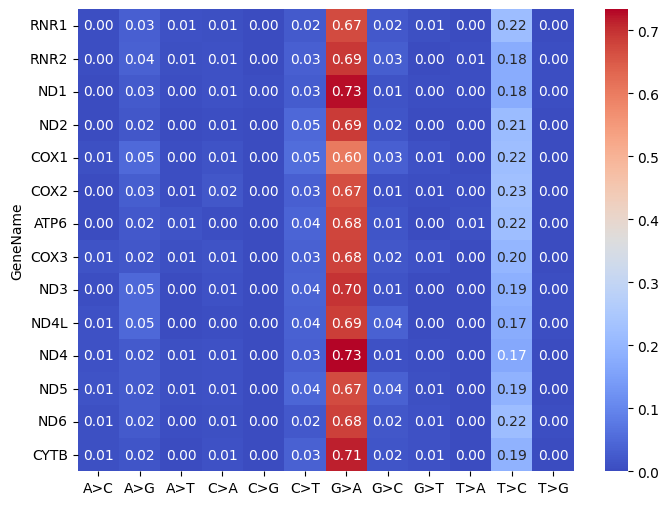

In [149]:
# in genome order
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    gene_spectra12.loc[ref_annot[ref_annot.GeneName.isin(used_genes)].GeneName.unique()], 
    cmap='coolwarm', annot=True, fmt='.2f');

In [148]:
ref_annot[ref_annot.GeneName.isin(used_genes)].GeneName.unique()

array(['RNR1', 'RNR2', 'ND1', 'ND2', 'COX1', 'COX2', 'ATP6', 'COX3',
       'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB'], dtype=object)

### Explore VAF

In [193]:
Turn

,TurnOverDays,DummyShortTurnoverTime,DummyMediumTurnoverTime,DummyLongTurnoverTime,TurnOverRank
tissue,,,,,
Uterus,4.0,True,False,False,1
Colon/Rectum,5.0,True,False,False,1
Stomach,5.5,True,False,False,1
Cervix,6.0,True,False,False,1
Esophagus,11.0,True,False,False,1
Head/Neck,16.0,True,False,False,1
Lymphoid,30.0,True,False,False,1
Myeloid,30.0,True,False,False,1
Breast,84.5,False,True,False,2


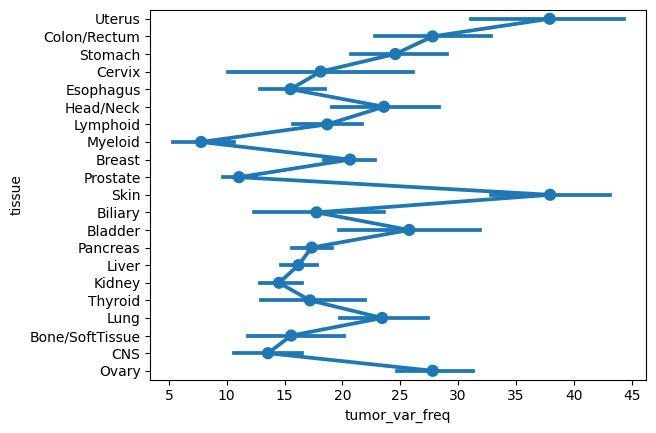

In [194]:
sns.pointplot(
    data=mut_tcga_ex_ctrl_reg, 
    x='tumor_var_freq', y='tissue', 
    order=Turn.index.values
);

In [195]:
mut_tcga_ex_ctrl_reg.corr('spearman')

,TurnOverDays,tumor_var_freq,Pos,Strand,PosInGene,PosInCodon,TBSS,Label
TurnOverDays,1.000000,-0.013894,0.046186,-0.003783,0.018821,0.008671,0.027199,-0.021770
tumor_var_freq,-0.013894,1.000000,-0.000272,0.009122,-0.000117,-0.015532,0.017164,-0.007952
Pos,0.046186,-0.000272,1.000000,-0.143716,0.522619,0.444747,0.534797,0.058724
Strand,-0.003783,0.009122,-0.143716,1.000000,0.310914,0.318323,-0.203696,0.056852
PosInGene,0.018821,-0.000117,0.522619,0.310914,1.000000,0.680735,0.178999,0.099917
PosInCodon,0.008671,-0.015532,0.444747,0.318323,0.680735,1.000000,0.069852,0.439292
TBSS,0.027199,0.017164,0.534797,-0.203696,0.178999,0.069852,1.000000,-0.009086
Label,-0.021770,-0.007952,0.058724,0.056852,0.099917,0.439292,-0.009086,1.000000
